# SAM3 Usage Guide: Aerial Maritime Image Segmentation

This notebook demonstrates how to use `getiprompt.SAM3` for zero-shot segmentation on aerial maritime images.

SAM3 supports two types of prompts:
1. **Text prompts**: Provide category names (e.g., "boat", "car")
2. **Box prompts**: Provide bounding boxes to segment specific objects

**Important**: SAM3 is a zero-shot model - it does NOT require a learning phase. You can directly use it for inference!


In [ ]:
# Import required libraries
import cv2
import matplotlib.pyplot as plt
import torch
from PIL import Image

from getiprompt.data.base import Sample
from getiprompt.data.utils.image import read_image
from getiprompt.models import SAM3
from getiprompt.visualizer import visualize_single_image

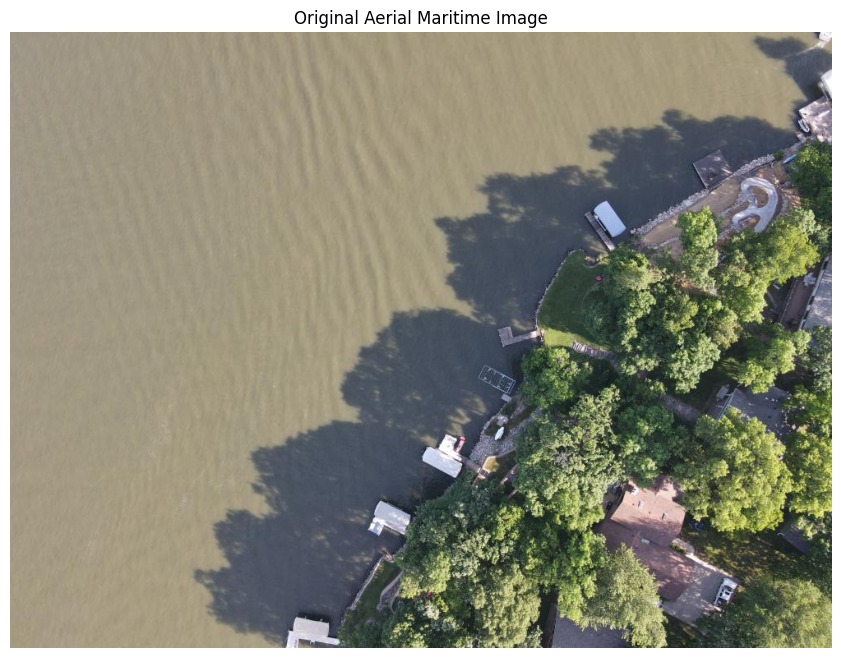

Image shape: torch.Size([3, 750, 1000])
Image size: 750x1000


In [ ]:
# Load the aerial maritime image
image_path = "assets/aerial_maritime/images/DJI_0261_JPG.rf.7e8b8b9fe532e59a56ba97e6deaa77b5.jpg"
image = read_image(image_path, as_tensor=True)

# Display the original image
plt.figure(figsize=(12, 8))
image_np = image.permute(1, 2, 0).numpy()
plt.imshow(image_np)
plt.axis("off")
plt.title("Original Aerial Maritime Image")
plt.show()

print(f"Image shape: {image.shape}")
print(f"Image size: {image.shape[1]}x{image.shape[2]}")

## Example 1: Text Prompt with Categories

In this example, we'll use text prompts to segment multiple object categories in the image. SAM3 will automatically detect and segment all instances of each category.


In [ ]:
# Initialize SAM3 model
# Note: SAM3 is zero-shot - no learning phase needed!

# Select the best available device: XPU (Intel) > CUDA (NVIDIA) > CPU
if hasattr(torch, "xpu") and torch.xpu.is_available():
    device = "xpu"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = SAM3(
    device=device,
    confidence_threshold=0.4,
)

print(f"Model initialized on {device}!")

Model initialized successfully!


In [ ]:
# Example 1: Text prompt with multiple categories
categories = ["boat", "jetski", "lift", "car", "dock"]

# Create a sample with text prompts
sample = Sample(
    image=image,
    categories=categories,
)

# Run predict
predictions = model.predict(sample)

# Get the prediction for the first (and only) image
prediction = predictions[0]

print(f"Found {len(prediction['pred_masks'])} segmented objects")
print(f"Categories detected: {set(prediction['pred_labels'])}")

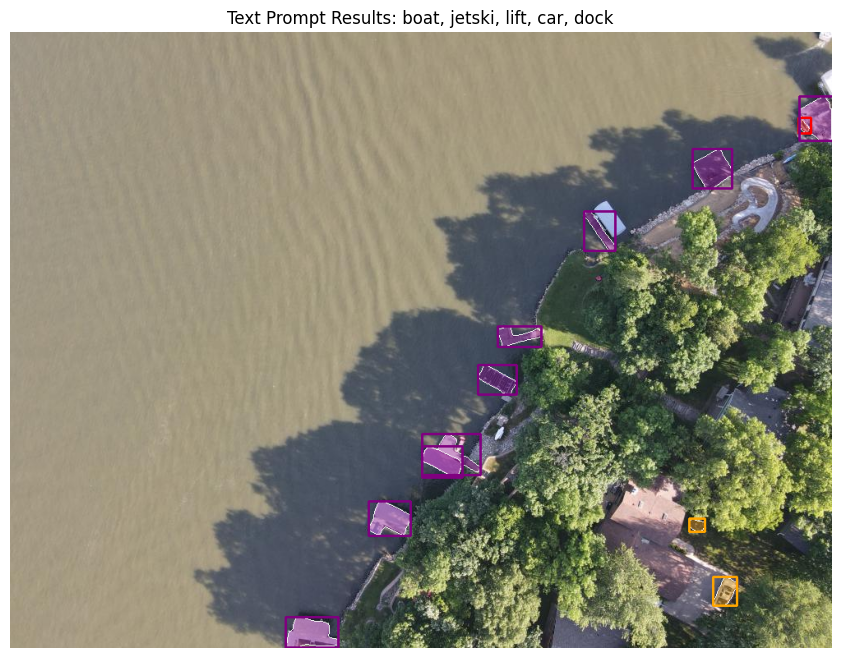

In [5]:
# Visualize the results with text prompts
# Define colors for each category
category_colors = {
    0: [255, 0, 0],  # Red
    1: [0, 255, 0],  # Green
    2: [0, 0, 255],  # Blue
    3: [255, 165, 0],  # Orange
    4: [128, 0, 128],  # Purple
}

# Visualize and save (output directory will be created automatically)
visualize_single_image(
    image,
    prediction,
    "sam3_text_prompt_result.png",
    "output",
    category_colors,
)

# Display the visualization
result_image = Image.open("output/sam3_text_prompt_result.png")
plt.figure(figsize=(12, 8))
plt.imshow(result_image)
plt.axis("off")
plt.title("Text Prompt Results: boat, jetski, lift, car, dock")
plt.show()

## Example 2: Single Box Prompt

**Note**: The provided box `[500, 500, 550, 550]` appears to be in XYXY format `[x1, y1, x2, y2]`.


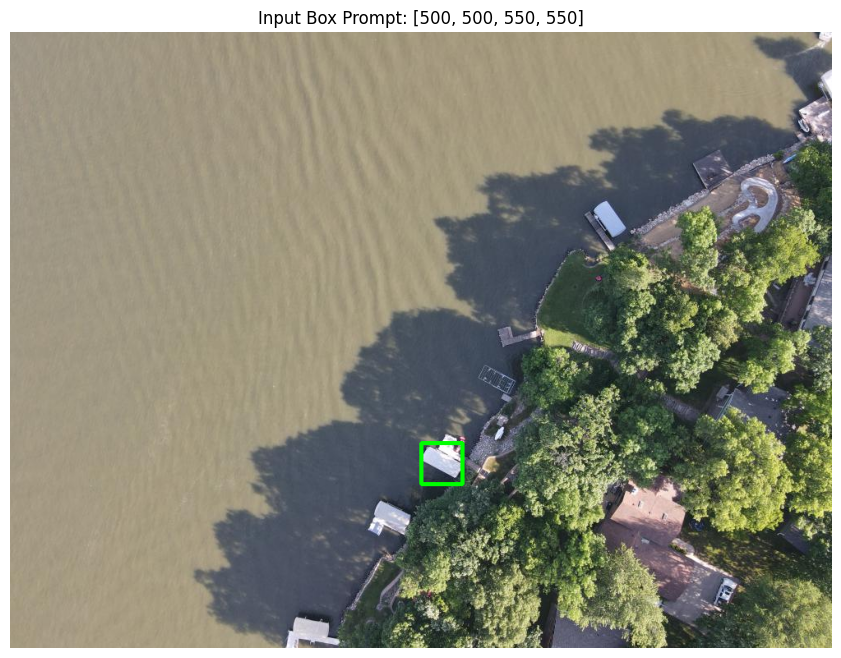

In [6]:
# Example 2: Box prompt
# The provided box is in XYXY format [x1, y1, x2, y2]
box_xyxy = [500, 500, 550, 550]

# Visualize the box on the image
image_np = image.permute(1, 2, 0).numpy().copy()
x1, y1, x2, y2 = box_xyxy
cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 3)

plt.figure(figsize=(12, 8))
plt.imshow(image_np)
plt.axis("off")
plt.title(f"Input Box Prompt: [{x1}, {y1}, {x2}, {y2}]")
plt.show()

In [5]:
# Create a sample with box prompt
# Note: bboxes should be a numpy array or torch tensor with shape [N, 4]
sample_box = Sample(
    image=image,
    bboxes=torch.tensor([box_xyxy]),  # Shape: [1, 4]
)

# Create a batch and run inference
predictions = model.predict(sample_box)

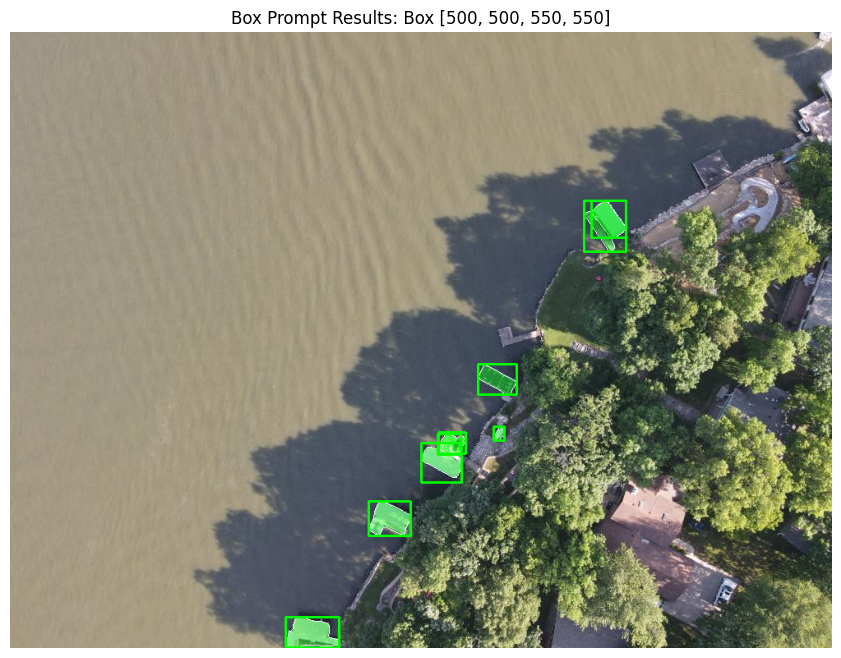

In [6]:
# Visualize the box prompt results
# For box prompts, labels are integer indices (0, 1, 2, ...)
# We'll use a single color for all box-prompted objects
num_objects = len(predictions[0]["pred_masks"])
box_colors = {i: [0, 255, 0] for i in range(num_objects)}  # Green for all objects

# Visualize and save
image_vis = visualize_single_image(
    image,
    predictions[0],
    "sam3_box_prompt_result.png",
    "output",
    box_colors,
)

# Display the visualization
plt.figure(figsize=(12, 8))
plt.imshow(image_vis)
plt.axis("off")
plt.title(f"Box Prompt Results: Box [{x1}, {y1}, {x2}, {y2}]")
plt.show()

## Summary

This notebook demonstrated two ways to use SAM3:

1. **Text Prompts**: Provide category names and SAM3 will detect and segment all instances
   - Use `Sample(image=image, categories=["category1", "category2", ...])`
   - Best for: When you know the object types you want to find

2. **Box Prompts**: Provide bounding boxes to segment specific objects
   - Use `Sample(image=image, bboxes=np.array([[x1, y1, x2, y2]]))`
   - Box format: `[x1, y1, x2, y2]`
   - Best for: When you have specific regions of interest

**Key Points**:
- SAM3 is zero-shot: No learning phase required!
- Both prompt types return masks, boxes, and scores
- Results are stored in `pred_masks`, `pred_boxes`, and `pred_labels`
